In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 2.x

In [4]:
!pip install pydicom

     |████████████████████████████████| 35.3MB 109kB/s 


In [0]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import glob
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator
import pydicom
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
import time
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [0]:
df=pd.read_csv('/content/drive/My Drive/Capstone Images sorted/covid/covid-chestxray-dataset-master/metadata.csv')

In [0]:
df['finding'].unique()

array(['COVID-19', 'ARDS', 'SARS', 'Pneumocystis', 'Streptococcus',
       'No Finding', 'Chlamydophila', 'E.Coli', 'COVID-19, ARDS',
       'Klebsiella', 'Legionella'], dtype=object)

In [0]:
only_covid=df[df['finding']=='COVID-19']
covid_ards=df[df['finding']=='COVID-19, ARDS']
only_covid_PA_AP_APSupine=only_covid[(only_covid['view']=='AP') | (only_covid['view']=='PA') | (only_covid['view']=='AP Supine')] #taking those rows who have covid 19 with view of AP,PA,AP Supine

In [0]:
covid_ards

,patientid,offset,sex,age,finding,survival,intubated,went_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 26
183,96,0.0,M,60.0,"COVID-19, ARDS",NaN,NaN,Y,NaN,NaN,NaN,89.0,NaN,NaN,NaN,PA,X-ray,2020,Spain,images,covid-19-pneumonia-rapidly-progressive-admissi...,NaN,https://radiopaedia.org/cases/covid-19-pneumon...,CC BY-NC-SA,Fever and odynophagia. Trip to Italy 7 days ag...,"Case courtesy of Dr Edgar Lorente, Radiopaedia...",NaN
184,96,1.0,M,60.0,"COVID-19, ARDS",NaN,NaN,Y,NaN,NaN,NaN,89.0,NaN,NaN,NaN,PA,X-ray,2020,Spain,images,covid-19-pneumonia-rapidly-progressive-12-hour...,NaN,https://radiopaedia.org/cases/covid-19-pneumon...,CC BY-NC-SA,Fever and odynophagia. Trip to Italy 7 days ag...,"Case courtesy of Dr Edgar Lorente, Radiopaedia...",NaN
185,96,3.0,M,60.0,"COVID-19, ARDS",NaN,NaN,Y,NaN,NaN,NaN,89.0,NaN,NaN,NaN,PA,X-ray,2020,Spain,images,covid-19-pneumonia-rapidly-progressive-3-days.jpg,NaN,https://radiopaedia.org/cases/covid-19-pneumon...,CC BY-NC-SA,Fever and odynophagia. Trip to Italy 7 days ag...,"Case courtesy of Dr Edgar Lorente, Radiopaedia...",NaN
186,97,0.0,F,70.0,"COVID-19, ARDS",NaN,Y,NaN,NaN,NaN,38.0,85.0,NaN,NaN,NaN,PA,X-ray,2020,Spain,images,covid-19-rapidly-progressive-acute-respiratory...,NaN,https://radiopaedia.org/cases/covid-19-rapidly...,CC BY-NC-SA,"Admitted with acute respiratory failure, fever...","Case courtesy of Dr Edgar Lorente, Radiopaedia...",NaN
187,97,1.0,F,70.0,"COVID-19, ARDS",NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,2020,Spain,images,covid-19-rapidly-progressive-acute-respiratory...,NaN,https://radiopaedia.org/cases/covid-19-rapidly...,CC BY-NC-SA,"Admitted with acute respiratory failure, fever...","Case courtesy of Dr Edgar Lorente, Radiopaedia...",NaN
188,97,2.0,F,70.0,"COVID-19, ARDS",NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,2020,Spain,images,covid-19-rapidly-progressive-acute-respiratory...,NaN,https://radiopaedia.org/cases/covid-19-rapidly...,CC BY-NC-SA,"Admitted with acute respiratory failure, fever...","Case courtesy of Dr Edgar Lorente, Radiopaedia...",NaN
189,97,3.0,F,70.0,"COVID-19, ARDS",NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,2020,Spain,images,covid-19-rapidly-progressive-acute-respiratory...,NaN,https://radiopaedia.org/cases/covid-19-rapidly...,CC BY-NC-SA,"Admitted with acute respiratory failure, fever...","Case courtesy of Dr Edgar Lorente, Radiopaedia...",NaN
224,117,6.0,M,50.0,"COVID-19, ARDS",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AP Supine,X-ray,2020,Spain,images,covid-19-pneumonia-evolution-over-a-week-1-day...,NaN,https://radiopaedia.org/cases/covid-19-pneumon...,CC BY-NC-SA,"Radiological worsening, with typical findings ...","Case courtesy of Dr Edgar Lorente, Radiopaedia...",NaN
279,160,4.0,M,44.0,"COVID-19, ARDS",N,NaN,NaN,NaN,NaN,NaN,NaN,0.22,NaN,NaN,PA,X-ray,"December 29, 2019",NaN,images,ryct.2020003.fig2-a.png,10.1148/ryct.2020200033,https://pubs.rsna.org/doi/10.1148/ryct.2020200033,NaN,progressively increased extension and density ...,NaN,NaN
280,160,5.0,M,44.0,"COVID-19, ARDS",N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"December 30, 2019",NaN,images,ryct.2020003.fig2-b.png,10.1148/ryct.2020200033,https://pubs.rsna.org/doi/10.1148/ryct.2020200033,NaN,progressively increased extension and density ...,NaN,NaN


In [0]:
covid_needed=pd.concat((only_covid_PA_AP_APSupine,covid_ards), axis=0) #joining covid19 with covid19 ,ards

In [0]:
c_map=covid_needed.loc[:,['patientid', 'finding', 'view', 'filename']]

In [0]:
c_map

,patientid,finding,view,filename
0,2,COVID-19,PA,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1,2,COVID-19,PA,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2,2,COVID-19,PA,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3,2,COVID-19,PA,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
4,4,COVID-19,PA,nejmc2001573_f1a.jpeg
...,...,...,...,...
189,97,"COVID-19, ARDS",PA,covid-19-rapidly-progressive-acute-respiratory...
224,117,"COVID-19, ARDS",AP Supine,covid-19-pneumonia-evolution-over-a-week-1-day...
279,160,"COVID-19, ARDS",PA,ryct.2020003.fig2-a.png
280,160,"COVID-19, ARDS",PA,ryct.2020003.fig2-b.png


In [0]:
c_map['filename'][0]

'auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg'

In [0]:
"""def load_dcm_images_p(folder):
    images = []
    for filename in os.listdir(folder):
      for i in pneumonia['patientId']: 
        if filename==i:  
          img = pydicom.dcmread(os.path.join(folder, filename))
          images.append(img.pixel_array)
    return images
pneumonia_700=load_dcm_images_p('/content/drive/My Drive/Capstone Images sorted/covid/rsna-pneumonia-detection-challenge/stage_2_train_images')
plt.imshow(pneumonia_700[0], cmap='gray')"""

In [0]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
      for i in c_map['filename']: 
        if filename==i:  
          img = cv2.imread(os.path.join(folder, filename), 1)
          img[...,::-1]
          images.append(img)
    return images

In [0]:
covid=load_images('/content/drive/My Drive/Capstone Images sorted/covid/covid-chestxray-dataset-master/images')

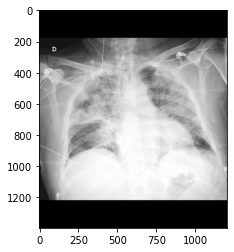

In [0]:
plt.imshow(covid[0])

In [0]:
src_dir = "/content/drive/My Drive/Capstone Images sorted/covid/covid-chestxray-dataset-master/images"
dst_dir = "/content/drive/My Drive/Capstone Images sorted/covid/covid_only"
c=0
for file in os.listdir(src_dir):
  for i in c_map['filename']: 
    if file==i:  
      shutil.copy(os.path.join(src_dir, file), dst_dir)
      c=c+1
      print(c)

'''for jpgfile in glob.iglob(os.path.join(src_dir, "*", "*.jpg")):
    shutil.copy(jpgfile, dst_dir)


for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
    shutil.copy(jpgfile, dst_dir) '''

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


'for jpgfile in glob.iglob(os.path.join(src_dir, "*", "*.jpg")):\n    shutil.copy(jpgfile, dst_dir)\n\n\nfor jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):\n    shutil.copy(jpgfile, dst_dir) '

# -------------------------------------------Covid Done---------------------

In [0]:
covid_data = []
for filename in os.listdir('/content/drive/My Drive/Capstone Images sorted/covid/covid_new'):
  img = cv2.imread(os.path.join('/content/drive/My Drive/Capstone Images sorted/covid/covid_new', filename), 1)
  img[...,::-1]
  covid_data.append(img)

In [0]:
covid_data=np.array(covid_data)

In [0]:
covid_data.shape

(283,)

In [0]:
datagen = ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               horizontal_flip=True,
                               brightness_range=(0.9, 1.1),
                               zoom_range=(0.85, 1.15),
                               fill_mode='constant',
                               dtype='float32')

In [0]:
aug_images=[]
c=0
for i in range(covid_data.shape[0]):
  samples = expand_dims(covid_data[i], 0)
  it = datagen.flow(samples, batch_size=1)
  for j in range(9):
    batch = it.next()
    image = batch[0].astype('uint8')
    cv2.imwrite('/content/drive/My Drive/Capstone Images sorted/covid/covid_aug_new/0000{}.jpg'.format(c), image)
    c=c+1

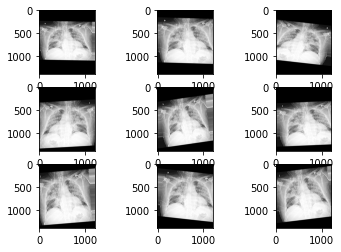

In [0]:

aug_images=[]
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	aug_images.append(image)
	pyplot.imshow(image)
# show the figure
pyplot.show()

# Now Dealing with healthy and pneumonia


In [0]:
df3=pd.read_csv('/content/drive/My Drive/Capstone Images sorted/covid/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')

In [0]:
df3['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [0]:
healthy=df3[df3['class']=='Normal']
pneumonia=df3[df3['class']=='Lung Opacity']

In [0]:
pneumonia=pneumonia.sample(2500, random_state=42)    #done for pneumonia     
healthy=healthy.sample(2500, random_state=42)          #done for healthy

In [0]:
pneumonia['patientId']=pneumonia['patientId']+'.dcm'
healthy['patientId']=healthy['patientId']+'.dcm'

In [0]:
src_dir = "/content/drive/My Drive/Capstone Images sorted/covid/rsna-pneumonia-detection-challenge/stage_2_train_images"
dst_dir = "/content/drive/My Drive/Capstone Images sorted/covid/healthy"
c=0
for file in os.listdir(src_dir):
  for i in healthy['patientId']: 
    if file==i:  
      shutil.copy(os.path.join(src_dir, file), dst_dir)
      c=c+1
      print(c)

In [0]:
src_dir = "/content/drive/My Drive/Capstone Images sorted/covid/rsna-pneumonia-detection-challenge/stage_2_train_images"
dst_dir = "/content/drive/My Drive/Capstone Images sorted/covid/pneumonia"
c=0
for file in tqdm(os.listdir(src_dir)):
  for i in pneumonia['patientId']: 
    if file==i:  
      shutil.copy(os.path.join(src_dir, file), dst_dir)
      c=c+1
      print(c)

In [0]:
healthy.to_csv('/content/drive/My Drive/Capstone Images sorted/covid/healthy_created.csv')
pneumonia.to_csv('/content/drive/My Drive/Capstone Images sorted/covid/pneumonia_created.csv')

# Copied to Drive

In [0]:
resized_covid = []
c=0
height = 256
width = 256
for filename in os.listdir('/content/drive/My Drive/Capstone Images sorted/covid/covid_aug_new'):
  img = cv2.imread(os.path.join('/content/drive/My Drive/Capstone Images sorted/covid/covid_aug_new', filename), 1)
  img = cv2.resize(img, (width,height), interpolation=cv2.INTER_CUBIC)
  img[...,::-1]
  cv2.imwrite('/content/drive/My Drive/Capstone Images sorted/covid/covid_aug_resized_new/0000{}.jpg'.format(c), img)
  c=c+1

In [0]:
c=0
height = 256
width = 256
for filename in tqdm(os.listdir('/content/drive/My Drive/Capstone Images sorted/covid/healthy')):
  img = pydicom.dcmread(os.path.join('/content/drive/My Drive/Capstone Images sorted/covid/healthy', filename), 1)
  image=img.pixel_array
  #image = cv2.imread(img)
  image = cv2.resize(image, (width,height), interpolation=cv2.INTER_CUBIC)
  image[...,::-1]
  cv2.imwrite('/content/drive/My Drive/Capstone Images sorted/covid/healthy_resized/{}0000{}.jpg'.format(filename,c), image)
  c=c+1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [0]:
c=0
height = 256
width = 256
for filename in tqdm(os.listdir('/content/drive/My Drive/Capstone Images sorted/covid/pneumonia')):
  img = pydicom.dcmread(os.path.join('/content/drive/My Drive/Capstone Images sorted/covid/pneumonia', filename), 1)
  image=img.pixel_array
  #image = cv2.imread(img)
  image = cv2.resize(image, (width,height), interpolation=cv2.INTER_CUBIC)
  image[...,::-1]
  cv2.imwrite('/content/drive/My Drive/Capstone Images sorted/covid/pneumonia_resized/{}0000{}.jpg'.format(filename,c), image)
  c=c+1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


# Resized covid healthy and pneumonia

In [5]:
covid_images = []
covid_name= []
label=[]
for filename in tqdm(os.listdir('/content/drive/My Drive/Capstone Images sorted/covid/covid_aug_resized_new')):
  img = cv2.imread(os.path.join('/content/drive/My Drive/Capstone Images sorted/covid/covid_aug_resized_new', filename), 1)
  img[...,::-1]
  covid_images.append(img)
  covid_name.append(filename)
  label.append([1,0,0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [6]:
len(covid_images)

2540

In [7]:
lst1=[1,2,3]
lst2=[5,6,7]
lst1+lst2

[1, 2, 3, 5, 6, 7]

In [8]:
pneumonia_images = []
pneumonia_name=[]
for filename in tqdm(os.listdir('/content/drive/My Drive/Capstone Images sorted/covid/pneumonia_resized')):
  img = cv2.imread(os.path.join('/content/drive/My Drive/Capstone Images sorted/covid/pneumonia_resized', filename), 1)
  img[...,::-1]
  pneumonia_images.append(img)
  pneumonia_name.append(filename)
  label.append([0,1,0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
len(pneumonia_images)

2235

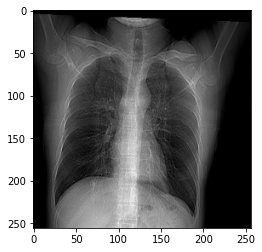

In [10]:
plt.imshow(covid_images[0])

In [11]:
healthy_images = []
healthy_name=[]
for filename in tqdm(os.listdir('/content/drive/My Drive/Capstone Images sorted/covid/healthy_resized')):
  img = cv2.imread(os.path.join('/content/drive/My Drive/Capstone Images sorted/covid/healthy_resized', filename), 1)
  img[...,::-1]
  healthy_images.append(img)
  healthy_name.append(filename)
  label.append([0,0,1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
len(healthy_images)

2500

In [0]:
final_data=covid_images+pneumonia_images+healthy_images

In [0]:
final_data=np.array(final_data)

In [15]:
len(final_data)

7275

In [0]:
X_train, X_test, y_train, y_test= train_test_split(final_data, label, test_size=0.3, random_state=42)

In [17]:
X_train[0].shape

(256, 256, 3)

In [0]:
X_train = X_train.reshape(len(X_train),256,256,3)
X_test = X_test.reshape(len(X_test),256,256,3)

In [0]:
y_train=np.array(y_train)
y_test=np.array(y_test)

# Model Inception v4

In [20]:
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(units=3, activation='softmax', name=name)(layer)
    return layer


def inception_v1():
    layer_in = Input(shape=(256, 256, 3))
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=3, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model


# train model
model = inception_v1()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [0]:
checkpoint_name = '/content/drive/My Drive/Capstone Images sorted/covid/Model_weights/Weights-{epoch:03d}--{val_aux1_accuracy:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_aux1_accuracy',save_best_only=True, verbose = 1, mode ='auto',)
callbacks_list = [checkpoint]

In [0]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

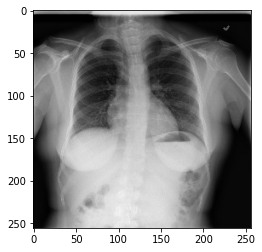

In [21]:
plt.imshow(X_train[0])

In [28]:
X_train.shape

(5092, 256, 256, 3)

In [29]:
y_train.shape

(5092, 3)

In [41]:
start_time = time.time()
model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=100,callbacks=callbacks_list) #2nd run
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/100
160/160 [==============================] - ETA: 0s - loss: 2.1438 - main_loss: 0.8491 - aux1_loss: 0.6271 - aux2_loss: 0.6676 - main_accuracy: 0.6610 - aux1_accuracy: 0.7465 - aux2_accuracy: 0.7217
Epoch 00001: val_aux1_accuracy improved from -inf to 0.70041, saving model to /content/drive/My Drive/Capstone Images sorted/covid/Model_weights/Weights-001--0.70041.hdf5
160/160 [==============================] - 198s 1s/step - loss: 2.1438 - main_loss: 0.8491 - aux1_loss: 0.6271 - aux2_loss: 0.6676 - main_accuracy: 0.6610 - aux1_accuracy: 0.7465 - aux2_accuracy: 0.7217 - val_loss: 2.2518 - val_main_loss: 0.7551 - val_aux1_loss: 0.7471 - val_aux2_loss: 0.7497 - val_main_accuracy: 0.7187 - val_aux1_accuracy: 0.7004 - val_aux2_accuracy: 0.7215
Epoch 2/100
160/160 [==============================] - ETA: 0s - loss: 1.2586 - main_loss: 0.4897 - aux1_loss: 0.3642 - aux2_loss: 0.4047 - main_accuracy: 0.8058 - aux1_accuracy: 0.8582 - aux2_accuracy: 0.8425
Epoch 00002: val_aux1_accuracy 

In [0]:
model = load_model('/content/drive/My Drive/Capstone Images sorted/covid/Model_weights/Weights-095--0.93678.hdf5')

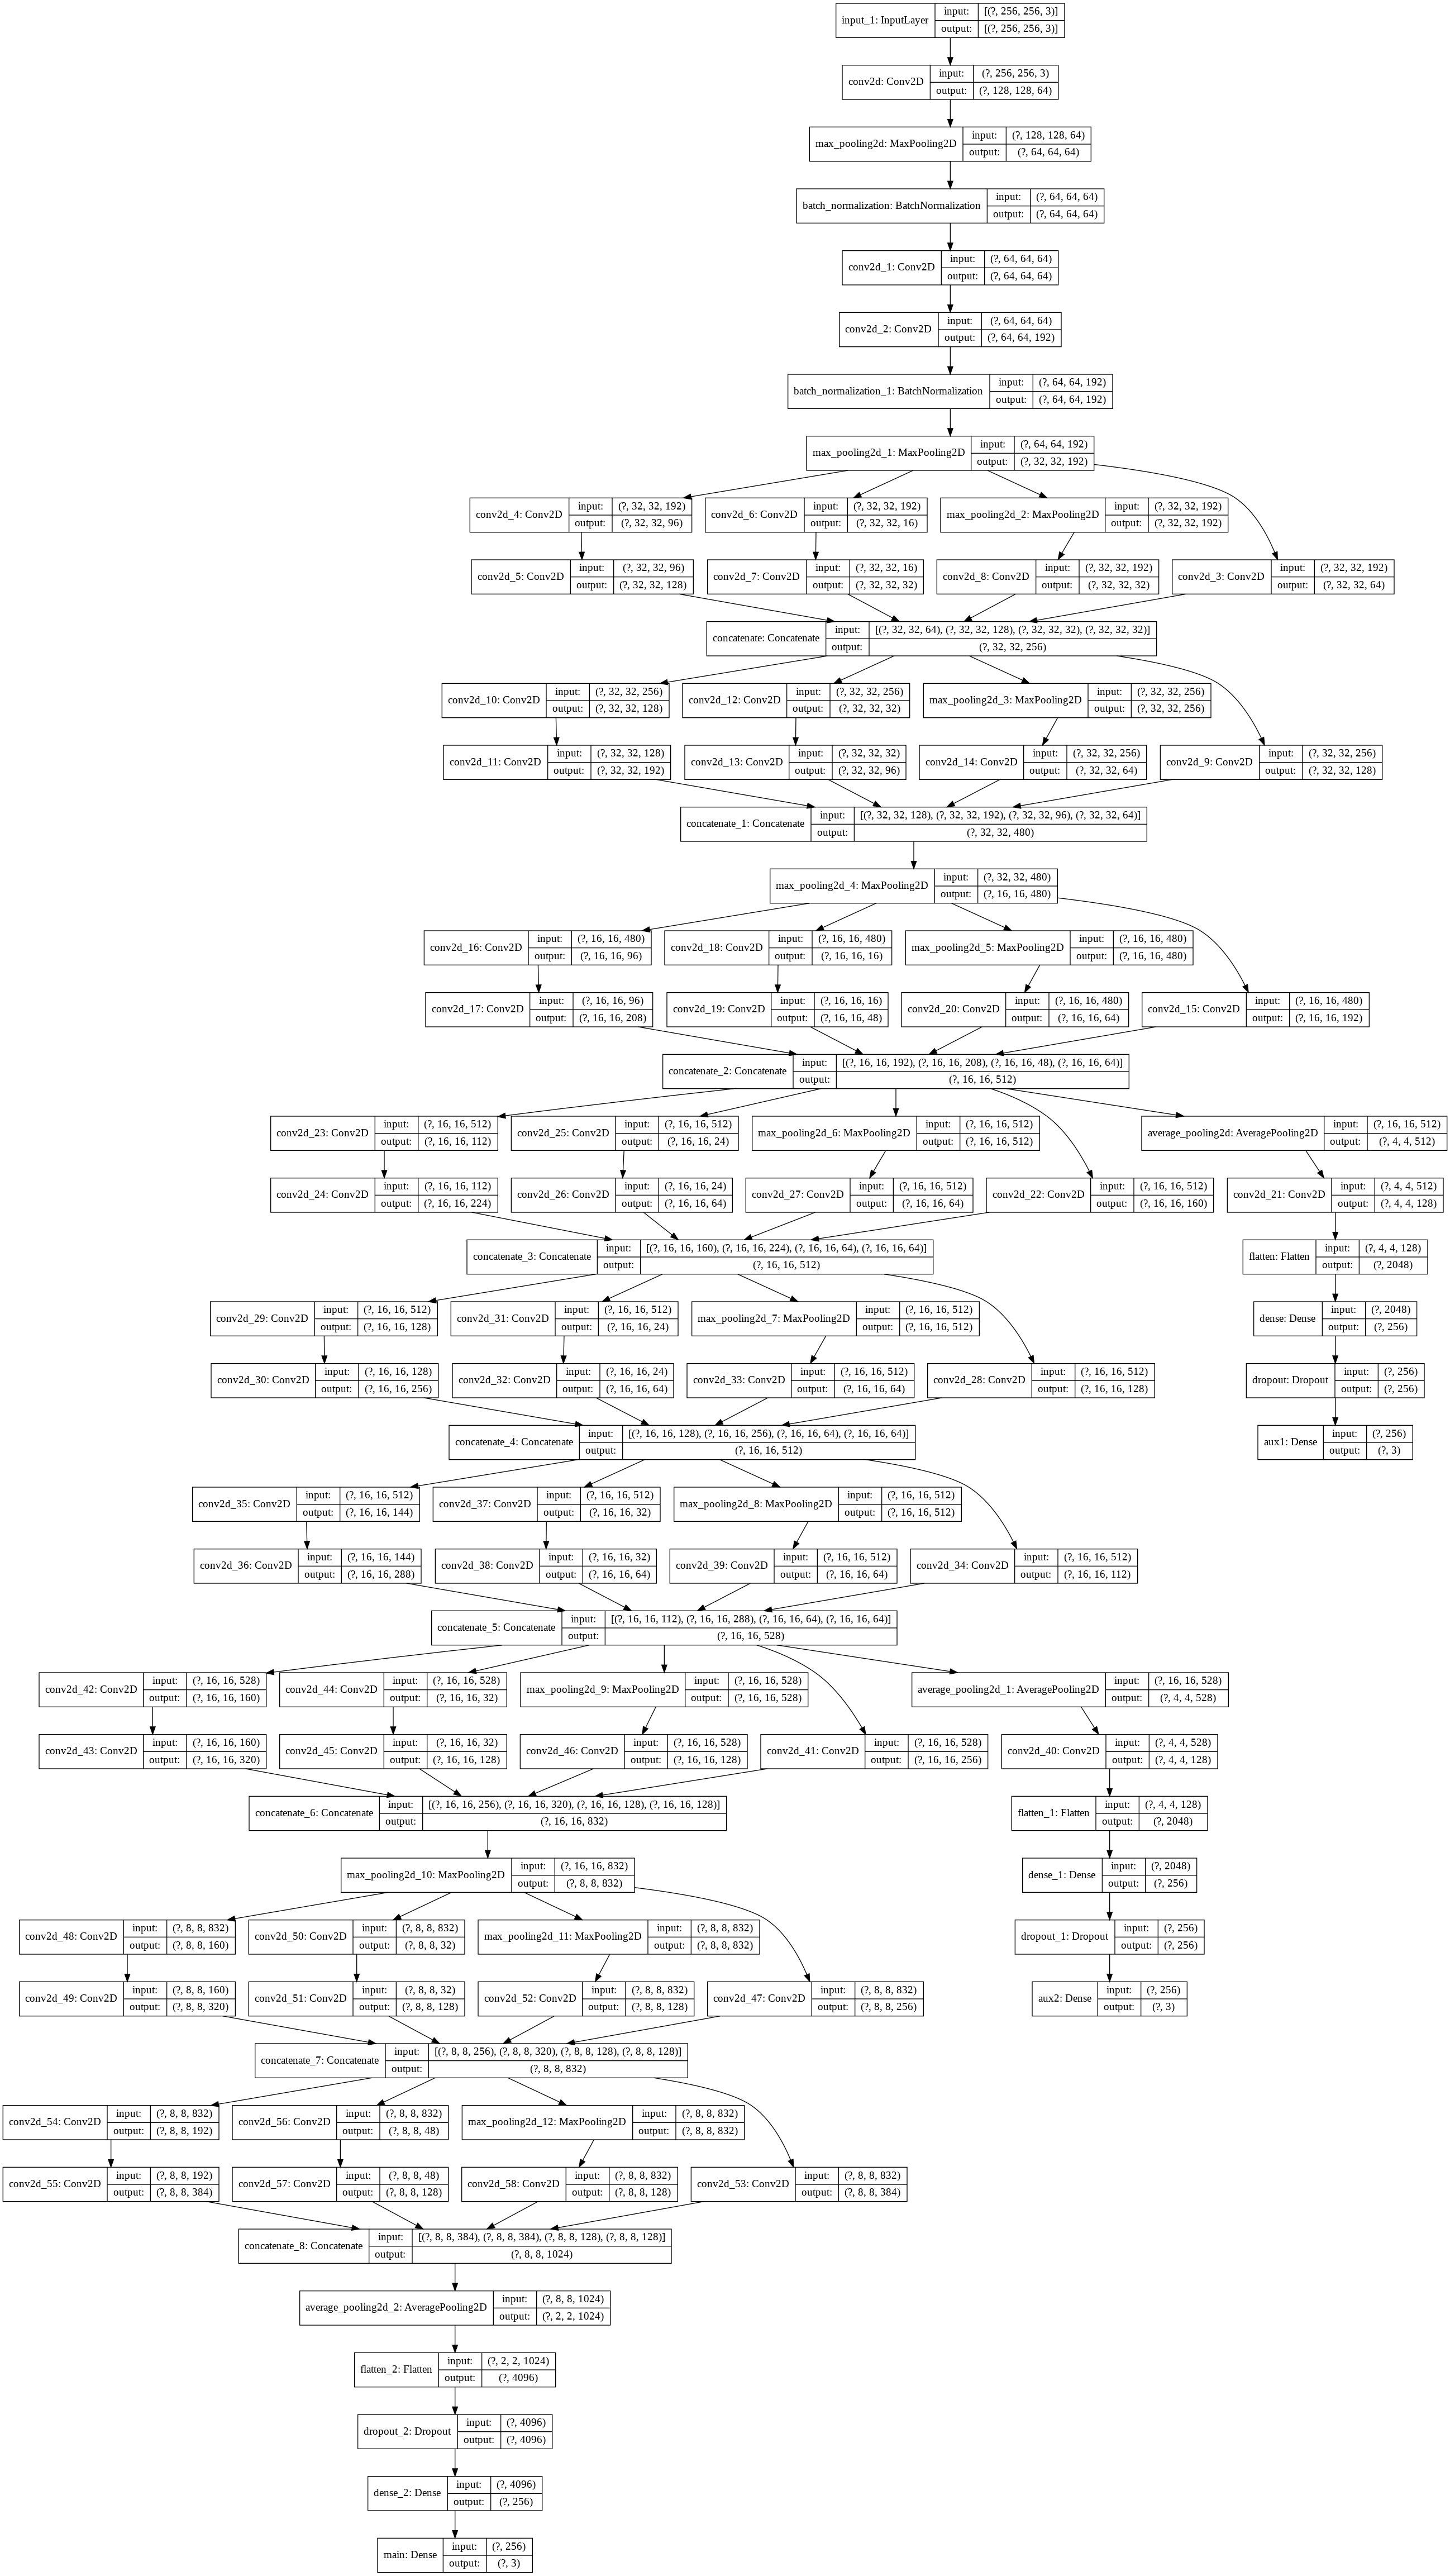

In [7]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [58]:
model.evaluate(X_test, y_test)

69/69 [==============================] - 12s 171ms/step - loss: 1.9529 - main_loss: 0.7407 - aux1_loss: 0.5923 - aux2_loss: 0.6199 - main_accuracy: 0.9340 - aux1_accuracy: 0.9368 - aux2_accuracy: 0.9345


[1.952892541885376,
 0.740683913230896,
 0.5922636985778809,
 0.61994469165802,
 0.9340357184410095,
 0.9367842674255371,
 0.9344938397407532]

In [97]:
max(aux_1_output[0])

1.0

In [0]:
pred=model.predict(X_test)

In [0]:
aux_1_output=pred[1]

In [86]:
len(aux_1_output)

2183

In [0]:
pred_classes=[]
for i,j in enumerate(aux_1_output):
  pred_classes.append(list(aux_1_output[i]).index(max(aux_1_output[i])))

In [0]:
true_classes=[]
for i,j in enumerate(y_test):
  true_classes.append(list(y_test[i]).index(max(y_test[i])))

In [118]:
print('Confusion Matrix : {}'.format(confusion_matrix(true_classes, pred_classes)))
print('Precision Score : {}'.format(precision_score(true_classes, pred_classes, average='weighted')))
print('Recall Score : {}'.format(recall_score(true_classes, pred_classes, average='weighted')))

Confusion Matrix : [[771  12   1]
 [ 11 583  69]
 [  2  43 691]]
Precision Score : 0.9368504046578437
Recall Score : 0.9367842418689877


In [0]:
model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=100) #1st run

Epoch 1/100
160/160 [==============================] - 171s 1s/step - loss: 2.0996 - main_loss: 0.8338 - aux1_loss: 0.5897 - aux2_loss: 0.6761 - main_accuracy: 0.6618 - aux1_accuracy: 0.7655 - aux2_accuracy: 0.7138 - val_loss: 2.6839 - val_main_loss: 0.9754 - val_aux1_loss: 0.8677 - val_aux2_loss: 0.8408 - val_main_accuracy: 0.5080 - val_aux1_accuracy: 0.6156 - val_aux2_accuracy: 0.5849
Epoch 2/100
160/160 [==============================] - 171s 1s/step - loss: 1.3004 - main_loss: 0.5054 - aux1_loss: 0.3781 - aux2_loss: 0.4169 - main_accuracy: 0.8160 - aux1_accuracy: 0.8621 - aux2_accuracy: 0.8476 - val_loss: 1.5640 - val_main_loss: 0.5231 - val_aux1_loss: 0.5166 - val_aux2_loss: 0.5244 - val_main_accuracy: 0.7794 - val_aux1_accuracy: 0.7652 - val_aux2_accuracy: 0.7588
Epoch 3/100
160/160 [==============================] - 171s 1s/step - loss: 1.0909 - main_loss: 0.4313 - aux1_loss: 0.3074 - aux2_loss: 0.3522 - main_accuracy: 0.8430 - aux1_accuracy: 0.8872 - aux2_accuracy: 0.8744 - val

In [0]:
"""inputs = Input(shape=(256, 256, 3))
x1 = Conv2D(filters=64,kernel_size=(7,7),strides=2,activation='relu',padding='same')(inputs)
x1 = MaxPool2D(pool_size=(3,3),padding='same',strides=2)(x1)

x2 = tf.nn.local_response_normalization()(x1)

x3 = Conv2D(filters=64,kernel_size=(1,1),strides=1,activation='relu',padding='same')(x2)
x3 = Conv2D(filters=192,kernel_size=(3,3),strides=1,activation='relu',padding='same')(x3)
x3 = tf.nn.local_response_normalization()(x3)
x3 = MaxPool2D(pool_size=(3,3),padding='same',strides=2)(x3)

#---------------------------------------------1st inception Block--------------------------------------------------------------


tower_0=Conv2D(64,(1,1),padding='same', strides=(1,1), activation='relu')(x3)

tower_1 = Conv2D(filters=64,kernel_size=(1,1),activation='relu')(x3)
tower_1 = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(tower_1)

tower_2 = Conv2D(filters=64,kernel_size=(1,1),activation='relu')(x3)
tower_2 = Conv2D(filters=64,kernel_size=(5,5),activation='relu')(tower_2)


tower_3 = MaxPooling2D((3,3),padding='same',strides=(1,1))(x3)
tower_3 = Conv2D(filters=64,kernel_size=(1,1),activation='relu')(tower_3)

x4 = keras.layers.concatenate([tower_0, tower_1, tower_2, tower_3])
#---------------------------------------------2nd Inception Block------------------------------------------------------------------

tower_0=Conv2D(64,(1,1),padding='same', strides=(1,1), activation='relu')(x4)

tower_1 = Conv2D(filters=64,kernel_size=(1,1),activation='relu')(x4)
tower_1 = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(tower_1)

tower_2 = Conv2D(filters=64,kernel_size=(1,1),activation='relu')(x4)
tower_2 = Conv2D(filters=64,kernel_size=(5,5),activation='relu')(tower_2)


tower_3 = MaxPooling2D((3,3),padding='same',strides=(1,1))(x4)
tower_3 = Conv2D(filters=64,kernel_size=(1,1),activation='relu')(tower_3)

x5 = keras.layers.concatenate([tower_0, tower_1, tower_2, tower_3])
x5 = MaxPooling2D((3,3),padding='same',strides=(2,2))(x5)
#---------------------------------------------3rd Inception Block------------------------------------------------------------------


tower_0=Conv2D(64,(1,1),padding='same', strides=(1,1), activation='relu')(x5)

tower_1 = Conv2D(filters=64,kernel_size=(1,1),activation='relu')(x5)
tower_1 = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(tower_1)

tower_2 = Conv2D(filters=64,kernel_size=(1,1),activation='relu')(x5)
tower_2 = Conv2D(filters=64,kernel_size=(5,5),activation='relu')(tower_2)


tower_3 = MaxPooling2D((3,3),padding='same',strides=(1,1))(x5)
tower_3 = Conv2D(filters=64,kernel_size=(1,1),activation='relu')(tower_3)

x6 = keras.layers.concatenate([tower_0, tower_1, tower_2, tower_3])

#---------------------------------------------4th Inception Block------------------------------------------------------------------
tower_0=Conv2D(64,(1,1),padding='same', strides=(1,1), activation='relu')(x6)

tower_1 = Conv2D(filters=64,kernel_size=(1,1),activation='relu')(x6)
tower_1 = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(tower_1)

tower_2 = Conv2D(filters=64,kernel_size=(1,1),activation='relu')(x6)
tower_2 = Conv2D(filters=64,kernel_size=(5,5),activation='relu')(tower_2)


tower_3 = MaxPooling2D((3,3),padding='same',strides=(1,1))(x6)
tower_3 = Conv2D(filters=64,kernel_size=(1,1),activation='relu')(tower_3)

x6 = keras.layers.concatenate([tower_0, tower_1, tower_2, tower_3])

   #---------------Result1--------------------
avg1=AveragePooling2D((3, 3), strides = (1, 1), padding = "same")(x6)

d1 = Flatten()(avg1)
d1 = Dense(units=1,activation='relu')(DNN)
DNN = BatchNormalization()(DNN)
DNN = Dropout(0.5)(DNN)
DNN = Dense(units=500,activation='relu')(DNN)
DNN = BatchNormalization()(DNN)
DNN = Dropout(0.5)(DNN)
DNN = Dense(units=100,activation='relu')(DNN)
DNN = BatchNormalization()(DNN)
DNN = Dropout(0.5)(DNN)
outputs = Dense(units=3,activation='softmax')(DNN)
my_model = Model(inputs = inputs,outputs=outputs)
   #-------------------------------------------

x = MaxPool2D(pool_size=(3,3),padding='same',strides=1)(x3)
x3_u = Conv2DTranspose(filters=64,kernel_size=(3,3),strides=2,padding='same',activation='relu')(x3)
x4 = x3_u+x2
x4 = Conv2D(filters=128,kernel_size=(1,1),strides=2,activation='relu',padding='same')(x4)
x4 = MaxPool2D(pool_size=(1,1),padding='same',strides=1)(x4)
x5 = Conv2D(filters=128,kernel_size=(1,1),strides=2,activation='relu',padding='same')(x4)
x5 = MaxPool2D(pool_size=(1,1),padding='same',strides=1)(x5)
x5_u = Conv2DTranspose(filters=128,kernel_size=(1,1),strides=2,padding='same',activation='relu')(x5)
x6=x5_u+x4
x6 = Conv2D(filters=256,kernel_size=(1,1),strides=2,activation='relu',padding='same')(x6)
x6 = MaxPool2D(pool_size=(1,1),padding='same',strides=1)(x6)
x7 = Conv2D(filters=256,kernel_size=(1,1),strides=2,activation='relu',padding='same')(x6)
x7 = MaxPool2D(pool_size=(1,1),padding='same',strides=1)(x7)
x7_u = Conv2DTranspose(filters=256,kernel_size=(1,1),strides=2,padding='same',activation='relu')(x7)
x8=x7_u+x6
x8 = Conv2D(filters=512,kernel_size=(1,1),strides=2,activation='relu',padding='same')(x8)
x8 = MaxPool2D(pool_size=(1,1),padding='same',strides=1)(x8)
x9 = Conv2D(filters=512,kernel_size=(1,1),strides=2,activation='relu',padding='same')(x8)
x9 = MaxPool2D(pool_size=(1,1),padding='same',strides=1)(x9)
x9_u = Conv2DTranspose(filters=512,kernel_size=(1,1),strides=2,padding='same',activation='relu')(x9)
cnn_output=x9_u+x8
DNN = Flatten()(cnn_output)
DNN = Dense(units=1000,activation='relu')(DNN)
DNN = BatchNormalization()(DNN)
DNN = Dropout(0.5)(DNN)
DNN = Dense(units=500,activation='relu')(DNN)
DNN = BatchNormalization()(DNN)
DNN = Dropout(0.5)(DNN)
DNN = Dense(units=100,activation='relu')(DNN)
DNN = BatchNormalization()(DNN)
DNN = Dropout(0.5)(DNN)
outputs = Dense(units=3,activation='softmax')(DNN)
my_model = Model(inputs = inputs,outputs=outputs)

In [169]:
covid_test = []
covid_test_label=[]
for filename in tqdm(os.listdir('/content/drive/My Drive/Capstone Images sorted/covid/test/covid')):
  img = cv2.imread(os.path.join('/content/drive/My Drive/Capstone Images sorted/covid/test/covid', filename), 1)
  img[...,::-1]
  covid_test.append(img)
  if filename=='1111.jpg':
    covid_test_label.append(2)
    break;
  covid_test_label.append(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
covid_test=np.array(covid_test)
covid_test=covid_test.reshape(len(covid_test),256,256,3)

In [0]:
pred_test=model.predict(covid_test)

In [0]:
pred_test=pred_test[0]

In [0]:
pred_covid=[]
for i,j in enumerate(pred_test):
  pred_covid.append(list(pred_test[i]).index(max(pred_test[i])))

In [178]:
pred_covid

[0, 0, 2, 0, 0, 2]

In [151]:
covid_test_label

[0, 0, 0, 0, 0, 2]

In [152]:
recall_score(covid_test_label, pred_covid, average='micro')

0.8333333333333334